In [1]:
import os
import pandas as pd
# from __future__ import unicode_literals
# import sys
import numpy as np
import re, math
import itertools
import editdistance
import fasttext
import math

from collections import Counter
from __future__ import print_function
from hashlib import md5, sha1, sha224
from sklearn.feature_extraction.text import TfidfVectorizer 
from nltk.translate import bleu_score
from nltk.tokenize import RegexpTokenizer
from preprocess_observation import FeatureExtractor
tokenizer = RegexpTokenizer(r'\w+')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# reload(sys)  
# sys.setdefaultencoding('utf-8')

In [57]:
data_path = "labeled"
paths = os.listdir(data_path)

In [58]:
df = pd.DataFrame(columns=['ref1', 'ref2', 'label'])

### Collecting labeled data

In [60]:
row = 0
for path in paths:     
    dir_name = os.path.join(data_path, path)
    with open(os.path.join(dir_name, 'description.txt')) as text:
        ideal_ref = text.readline()#.lower()   
    print ('ideal', ideal_ref)

    for root, dirs, files in os.walk(dir_name):
        for f in files:
            if f.endswith('out.txt') or f.endswith('out-.txt'):      
                with open(os.path.join(root, f)) as txt:  
                    try:
                        refs = txt.readlines()
                        for ref in refs:
                            row += 1
                            if len(ref) > 10 and ref[0] == '+':
                                df.loc[row] = [ideal_ref, ref, 1]
                            elif len(ref) > 10:
                                df.loc[row] = [ideal_ref, ref, 0]
                    except UnicodeDecodeError:
                        continue

ideal Козырева О.А. СПЕЦИФИКА СОЗДАНИЯ ПЕДАГОГИЧЕСКИХ УСЛОВИЙ ВКЛЮЧЕНИЯ БУДУЩЕГО ПЕДАГОГА В НАУЧНО-ИССЛЕДОВАТЕЛЬСКУЮ РАБОТУ. Вестник Кемеровского государственного университета.  2015. № 2-3.  С. 63-67
ideal Полтерович В. Стратегии модернизации, институты и коалиции. Вопросы экономики.  2008. № 4.  С. 4-24
ideal Демьянов А.В., Котов А.Ю., Симбирцев А.С. Диагностическая ценность исследования уровней цитокинов в клинической практике. Цитокины и воспаление.  2003. Т. 2. № 3.  С. 20-35
ideal Баранов А.А., Щеплягина Л.А., Ильин А.Г., Кучма В.Р. СОСТОЯНИЕ ЗДОРОВЬЯ ДЕТЕЙ КАК ФАКТОР НАЦИОНАЛЬНОЙ БЕЗОПАСНОСТИ. Российский педиатрический журнал.  2005. № 2.  С. 4-8
ideal Козырева О.А. ТЕХНОЛОГИЯ СИСТЕМНО-ПЕДАГОГИЧЕСКОГО МОДЕЛИРОВАНИЯ И КАЧЕСТВО ФОРМИРОВАНИЯ КУЛЬТУРЫ САМОСТОЯТЕЛЬНОЙ РАБОТЫ ПЕДАГОГОВ: ТЕОРЕТИЧЕСКИЙ АСПЕКТ. European Social Science Journal.  2014. № 4-1 (43).  С. 136-142
ideal Полтерович В.М. Трансплантация экономических институтов. Экономическая наука современной России.  2001. № 3. 

In [65]:
df['ref2'] = df['ref2'].str.lstrip('+')

### Feature generation

In [67]:
def text_to_vector(text):
    words = tokenizer.tokenize(text)
    return Counter(words)

def cosine(row):     
    text1, text2 = row[0], row[1]
    vec1 = text_to_vector(text1)
    vec2 = text_to_vector(text2)
    
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x]**2 for x in vec1.keys()])
    sum2 = sum([vec2[x]**2 for x in vec2.keys()])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / float(denominator)

def levenshtein(row):
    text1, text2 = row[0], row[1]
    return int(editdistance.eval(text1, text2))

def create_trigrams(text):
    return zip(*[text[i:] for i in range(3)])    

def jaccard(row):  
    text1, text2 = row[0], row[1]
    intersection_cardinality = len(set.intersection(*[set(create_trigrams(text1)), set(create_trigrams(text2))]))
    union_cardinality = len(set.union(*[set(create_trigrams(text1)), set(create_trigrams(text1))]))
    return intersection_cardinality/float(union_cardinality)

def tfidf_cosine(row):
    tfidf_vect = TfidfVectorizer()
    refs = row[:2]
    try:
        X = tfidf_vect.fit_transform(refs).toarray()
        row_sums = X.sum(axis=1)
        X = X / row_sums[:, np.newaxis]

        numerator = np.dot(X[0], X[1])

        sum1 = sum(X[0]**2)
        sum2 = sum(X[1]**2)
        denominator = math.sqrt(sum1) * math.sqrt(sum2)

        if not denominator:
            return 0.0
        else:
            return float(numerator) / denominator
    except UnicodeDecodeError:
        return 0

def bleu(row):
    text1, text2 = row[0], row[1]
    try:
        return bleu_score.sentence_bleu([text1], text2)
    except ZeroDivisionError:
        return 0

In [68]:
updates = dict()
hash1 = lambda x: int(md5(x).hexdigest(), 16)
hash2 = lambda x: int(sha1(x).hexdigest(), 16)
hash3 = lambda x: int(sha224(x).hexdigest(), 16)
dim = 64
ampl = 10

def compute_updates(word):
    word = word.encode('utf-8')
    pos1 = hash1(word) % dim
    pos2 = hash2(word) % dim
    delta1 = hash3(word) % (2 * ampl + 1) - ampl
    delta2 = ampl - hash3(word) % (2 * ampl + 1)
    return (pos1, delta1), (pos2, delta2)

def get_updates(word):
    global updates
    if word in updates:
        return updates[word]
    else:
        updates[word] = compute_updates(word)
        return updates[word]

def simhash(bag_of_words):
    v = [0] * dim
    wc = Counter(bag_of_words)
    for word, count in wc.items():
        for upd in get_updates(word):
            pos, delta = upd
            v[pos] += count * delta

    res = 0
    for i in range(dim):
        if v[i] > 0:
            res |= 1 << i
    return res

def distance(s1, s2):
    d = 0
    for i in range(dim):
        if s1 & 1 << i != s2 & 1 << i:
            d += 1
    return d

def simhash_feature(row):
    text1, text2 = row[0], row[1]
    s1 = simhash(text1.split())
    s2 = simhash(text2.split())
    return distance(s1, s2)

In [69]:
df['cosine'] = df.apply(cosine, axis=1) 
df['levenshtein'] = df.apply(levenshtein, axis=1) 
df['jaccard'] = df.apply(jaccard, axis=1) 
df['tf_idf_cosine'] = df.apply(tfidf_cosine, axis=1)
df['bleu'] = df.apply(bleu, axis=1) 
df['simhash'] = df.apply(simhash_feature, axis=1) 

In [2]:
model = fasttext.load_model('fasttext_models/model_unlemm_ft.bin')

def fasttext(tokens, num_text, X, vectorizer):
    result_vector = np.zeros(100)
    for token in tokens:
        if sum(model[token]) != 0 and token in vectorizer.get_feature_names():
            index = vectorizer.get_feature_names().index(token)
            tfidf = X[num_text, index]
            weighted = np.multiply(model[token], tfidf)
            result_vector = np.add(result_vector, weighted)            
    return result_vector

def weighted_fasttext(row):
    text1, text2 = row[0], row[1]
    tfidf_vectorizer = TfidfVectorizer()
    X = tfidf_vectorizer.fit_transform([text1, text2]).toarray()
    tokens1 = [t.lower() for t in tokenizer.tokenize(text1)]
    tokens2 = [t.lower() for t in tokenizer.tokenize(text2)]
    
    weighted_vec1 = fasttext(tokens1, 0, X, tfidf_vectorizer)
    weighted_vec2 = fasttext(tokens2, 1, X, tfidf_vectorizer)

    numerator = np.dot(weighted_vec1, weighted_vec2)

    sum1 = sum(weighted_vec1**2)
    sum2 = sum(weighted_vec2**2)
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator

In [6]:
df['ft'] = df.apply(weighted_fasttext, axis=1)

In [ ]:
df = df.dropna()

In [15]:
df.to_csv('df/labeled/df.csv', index=False)
# train.to_csv('df/labeled/train.csv', index=False)
# test.to_csv('df/labeled/test.csv', index=False)

## Histograms of feature values

In [54]:
is_dup = df[df.label == 1]

In [70]:
def plot_histograms(metric, df):
    dup = sorted(list(df[df.label == 1][metric]))
    non_dup = sorted(list(df[df.label == 0][metric]))

    fig, ax = plt.subplots(figsize=(17,9))
    ax.hist(dup, fc=(0, 0, 1, 0.5), normed=True, bins=20, label='duplicates')
    ax.hist(non_dup, fc=(1, 0, 0, 0.5), normed=True, bins=20, label='non_duplicates')

    ax.legend(loc='upper right', prop={'size': 20})
    ax.set_title('Histograms of {} value'.format(metric), fontsize=20)
    ax.set_xlabel('{} value'.format(metric))
    ax.set_ylabel('')
    plt.savefig('pics/'+ metric + '.png')
    plt.show();

/home/local/AP-TEAM/manokhina/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


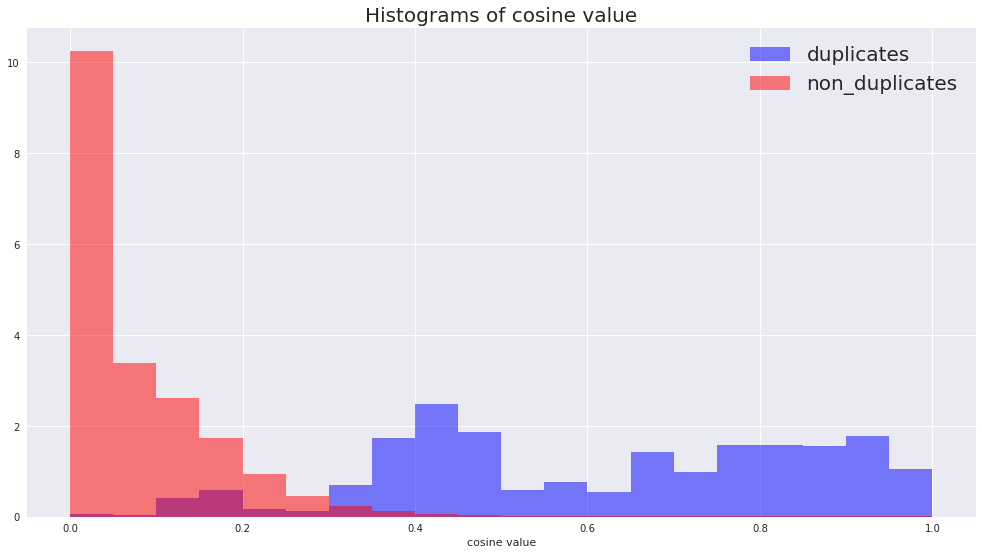

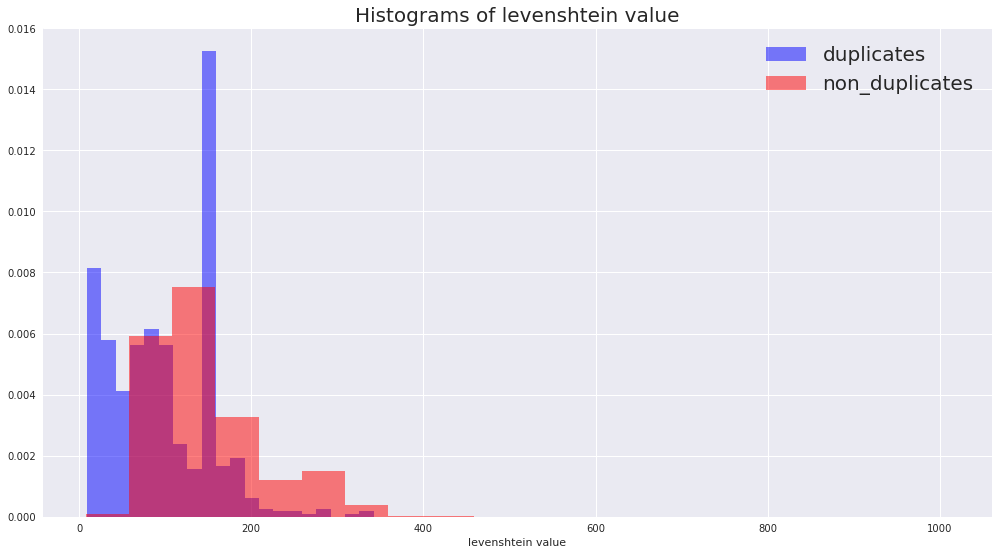

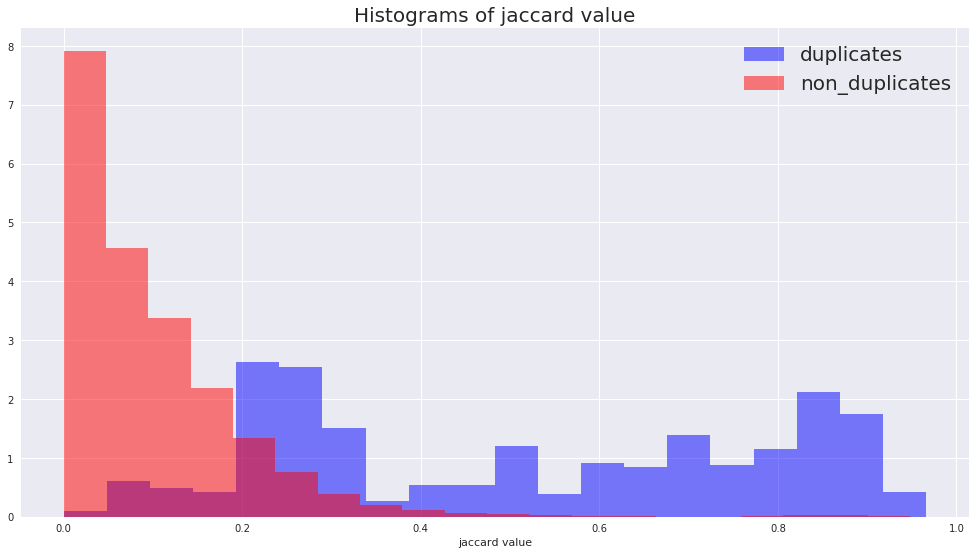

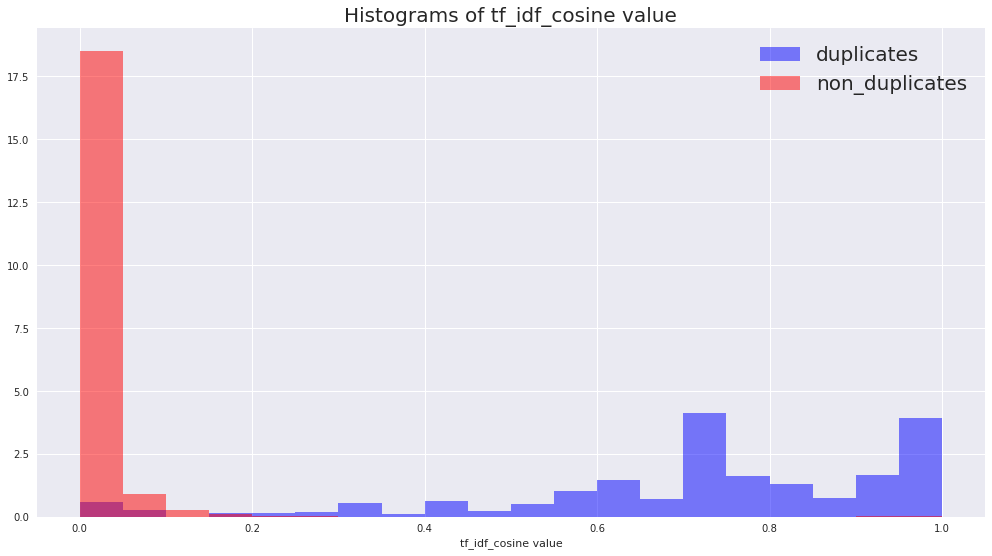

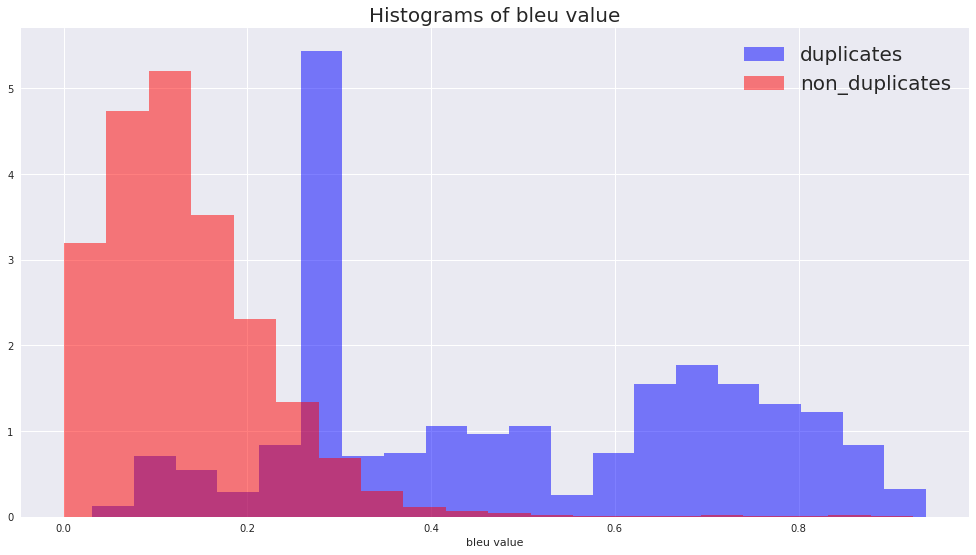

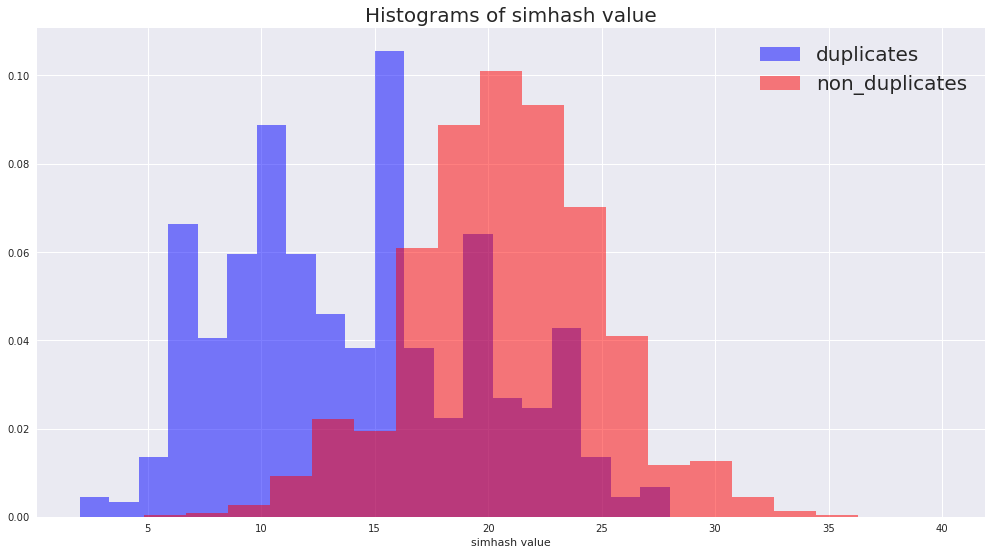

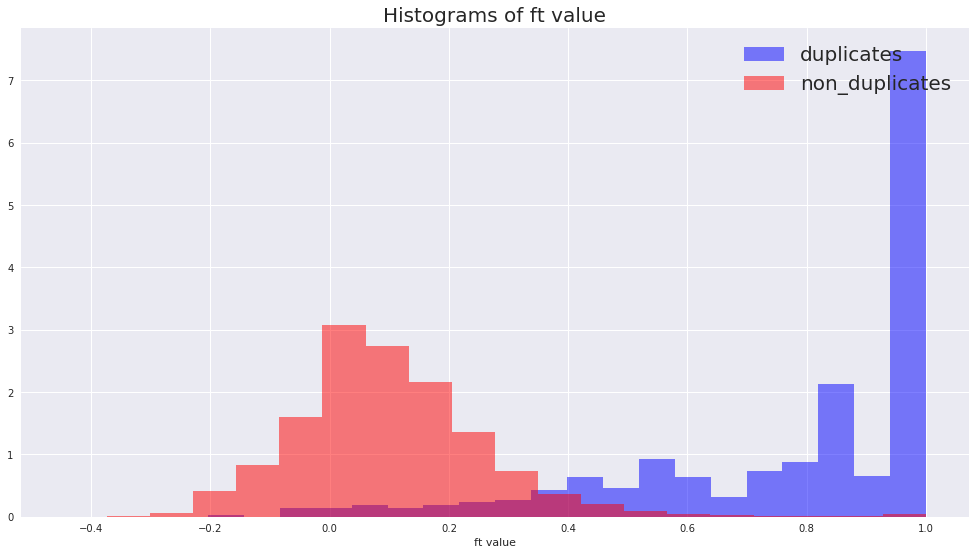

In [71]:
for metric in df.columns[3:]:
    plot_histograms(metric, df)